# Capturing greenhouse gases with data

## Model Development

### by Zachary Brown

Now that my dataset has been cleaned, explored, and preprocessed, it's time to begin testing a range of models to determine which can best predict the volumetric CO2 working capacity and then explore which features boost that capacity the most.

I'll start by installing the necessary libraries and then importing everything we'll need.

In [2]:
!pip install xgboost==1.7.4
!pip install lightgbm==3.3.5

     ---------------------------------------- 89.1/89.1 MB 9.3 MB/s eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 8.1 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
from matplotlib import rcParams

In [6]:
sns.set_theme('notebook')
rcParams['mathtext.default'] = 'regular'

Let's start by importing the training data.

In [12]:
X_train = pd.read_csv('../data/processed/X_train.csv', index_col = 'filename')
y_train = pd.read_csv('../data/processed/y_train.csv', index_col = 0)

In [13]:
X_train.head()

,unit_cell_volume,Density,accessible_surface_area,volumetric_surface_area,gravimetric_surface_area,accessible_volume_per_uc,volume_fraction,grav_volume,probe_occupiable_vol,probe_occ_vol_frac,...,lc-S-0-all,lc-S-1-all,lc-S-2-all,lc-S-3-all,lc-alpha-0-all,lc-alpha-1-all,lc-alpha-2-all,lc-alpha-3-all,D_lc-chi-2-all,D_lc-S-2-all
filename,,,,,,,,,,,,,,,,,,,,,
DB0-m2_o8_o14_f0_pcu.sym.96.cif,2835.48,0.594287,639.155,2254.13,3793.01,710.004,0.25040,0.421345,1739.57,0.6135,...,0.542767,0.759733,1.3000,1.176967,36.98,95.673333,136.635076,138.339640,1.480000,0.213333
DB0-m2_o6_o25_f0_pcu.sym.25.cif,3731.46,0.378038,798.181,2139.06,5658.31,1873.340,0.50204,1.328010,3057.93,0.8195,...,0.542767,0.567233,0.9225,0.759733,36.98,67.800000,86.526667,95.673333,0.756667,-0.033333
DB0-m29_o89_o148_f0_pts.sym.12.cif,1977.56,0.774433,393.895,1991.83,2571.98,333.139,0.16846,0.217527,1054.04,0.5330,...,0.532900,0.562100,1.0950,1.124200,28.09,59.890000,87.980000,119.780000,0.890000,-0.040000
DB0-m9_o3_o7_f0_sra.sym.2.cif,4622.09,0.533492,697.715,1509.52,2829.52,1820.640,0.39390,0.738343,3064.45,0.6630,...,0.532900,0.562100,1.0950,1.124200,28.09,59.890000,87.980000,119.780000,0.890000,-0.040000
DB0-m2_o21_o22_f0_pcu.sym.120.cif,1861.23,0.576000,416.902,2239.93,3888.77,493.449,0.26512,0.460278,1209.80,0.6500,...,0.542767,0.567233,0.9225,1.034467,36.98,67.800000,86.526667,118.844205,0.756667,-0.033333


In [14]:
y_train.head()

,0
0,5.853326
1,1.588771
2,16.626334
3,4.305267
4,2.952315


Now I want to perform an initial train/test split using just 10% of this data to train initial models so I can get a quick feel for how well each model will perform.

In [15]:
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.9, random_state=15)

In [16]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((20475, 450), (184275, 450), (20475, 1), (184275, 1))

In [17]:
# Reshape y_train for model fitting
y_tr = y_tr.values.ravel()
y_te = y_te.values.ravel()

In [18]:
y_tr.shape, y_te.shape

((20475,), (184275,))

Now I'm ready to start making some models. I'll begin with dummy models using mean and median to set a baseline to determine whether the other models are any good at all. I'll also build a dataframe called train_scores to keep track of the model scores so I can plot my progress as I go. 

In [21]:
dummy_mean = DummyRegressor(strategy="mean")
dummy_mean.fit(X_tr, y_tr)
y_pred = dummy_mean.predict(X_te)
train_scores = pd.DataFrame([{'Model' : 'Mean Dummy Regressor', '% Train Data' : 10, 'MSE' : mean_squared_error(y_te, y_pred)}])
print(mean_squared_error(y_te, y_pred))

408.1175428970218


In [22]:
dummy_median = DummyRegressor(strategy="median")
dummy_median.fit(X_tr, y_tr)
y_pred = dummy_median.predict(X_te)
new_row = pd.DataFrame([{'Model' : 'Median Dummy Regressor', '% Train Data' : 10, 'MSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
print(mean_squared_error(y_te, y_pred))

482.09093698996935


In [23]:
train_scores

,Model,% Train Data,MSE
0,Mean Dummy Regressor,10,408.117543
0,Median Dummy Regressor,10,482.090937


Now I'll start with an OLS regressor, then ridge and lasso.

In [24]:
ols = LinearRegression()
ols.fit(X_tr, y_tr)
y_pred = ols.predict(X_te)
new_row = pd.DataFrame([{'Model' : 'OLS', '% Train Data' : 10, 'MSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
print(mean_squared_error(y_te, y_pred))

26.28631125947099


For the rest of the models I'm exploring I'll need to do some hyperparameter tuning. To do so I'll use 60 iterations of random search CV to help narrow down where the hyperparameters are optimized, then I'll generate the models.

In [34]:
parameters = {'alpha': sp_randFloat(0.1,100)}
ridge = Ridge(random_state = 15)
ridge_reg = RandomizedSearchCV(ridge, parameters,scoring=['neg_root_mean_squared_error'],\
                               refit='neg_root_mean_squared_error', n_iter=60, cv=5)
random_ridge = ridge_reg.fit(X_tr, y_tr)
random_ridge.best_params_

{'alpha': 1.944279937536475}

I want to confirm that I'm finding a good spot for the alpha and make sure I don't need to adjust my bounds, so I'm going to plot the alphas against RMSE from the random search, and possible rerun it with a new range. I'll need to call the column names to know which ones I want to plot.

In [35]:
random_ridge_results = pd.DataFrame(random_ridge.cv_results_)
random_ridge_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'params', 'split0_test_neg_root_mean_squared_error',
       'split1_test_neg_root_mean_squared_error',
       'split2_test_neg_root_mean_squared_error',
       'split3_test_neg_root_mean_squared_error',
       'split4_test_neg_root_mean_squared_error',
       'mean_test_neg_root_mean_squared_error',
       'std_test_neg_root_mean_squared_error',
       'rank_test_neg_root_mean_squared_error'],
      dtype='object')

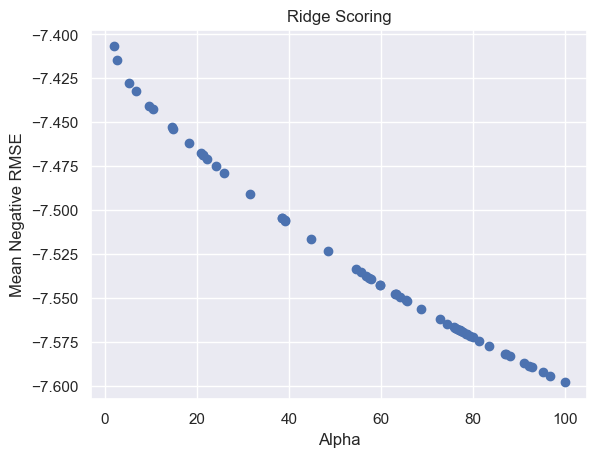

In [36]:
plt.plot(random_ridge_results['param_alpha'], random_ridge_results['mean_test_neg_root_mean_squared_error'], marker='o',\
         linestyle='none')
plt.title('Ridge Scoring')
plt.xlabel('Alpha')
plt.ylabel('Mean Negative RMSE')
plt.show()

So there's not a big change in RMSE, but I definitely want to move to smaller values.

In [37]:
parameters = {'alpha': sp_randFloat(0.001,5)}
ridge = Ridge(random_state = 15)
ridge_reg = RandomizedSearchCV(ridge, parameters,scoring=['neg_root_mean_squared_error'],\
                               refit='neg_root_mean_squared_error', n_iter=60, cv=5)
random_ridge = ridge_reg.fit(X_tr, y_tr)
random_ridge.best_params_

{'alpha': 0.016706715921523507}

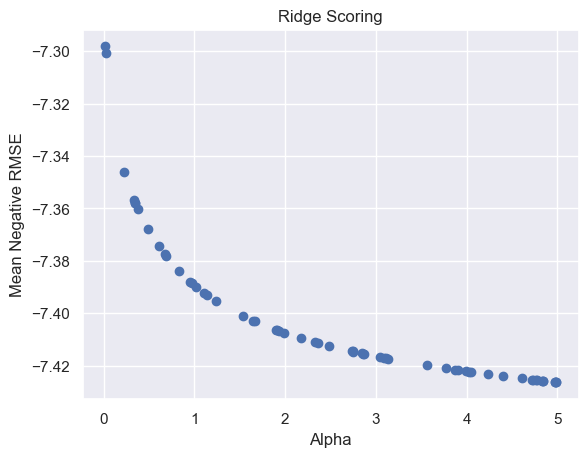

In [38]:
random_ridge_results = pd.DataFrame(random_ridge.cv_results_)
plt.plot(random_ridge_results['param_alpha'], random_ridge_results['mean_test_neg_root_mean_squared_error'], marker='o',\
         linestyle='none')
plt.title('Ridge Scoring')
plt.xlabel('Alpha')
plt.ylabel('Mean Negative RMSE')
plt.show()

That's good enough for right now, let's add this to the results dataframe and move on.

In [39]:
ridge=Ridge(alpha=random_ridge.best_params_['alpha'], random_state = 15)
ridge.fit(X_tr, y_tr)
y_pred = ridge.predict(X_te)
new_row = pd.DataFrame([{'Model' : 'Ridge', '% Train Data' : 10, 'MSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
print(mean_squared_error(y_te, y_pred))

26.128287689805486


On to lasso regression.

In [44]:
parameters = {'alpha': sp_randFloat(40,80)}
lasso = linear_model.Lasso(tol = 0.01, random_state = 15)
rand = RandomizedSearchCV(lasso, parameters, scoring=['neg_root_mean_squared_error'],\
                          refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=0)
rand_lasso = rand.fit(X_tr, y_tr)
rand_lasso.best_params_

C:\Users\zbro1\anaconda\envs\MOF\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.893e+04, tolerance: 6.528e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\zbro1\anaconda\envs\MOF\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.124e+05, tolerance: 6.526e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\zbro1\anaconda\envs\MOF\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

C:\Users\zbro1\anaconda\envs\MOF\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.014e+05, tolerance: 6.469e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\zbro1\anaconda\envs\MOF\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.153e+05, tolerance: 6.498e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\zbro1\anaconda\envs\MOF\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

{'alpha': 69.18202991034835}

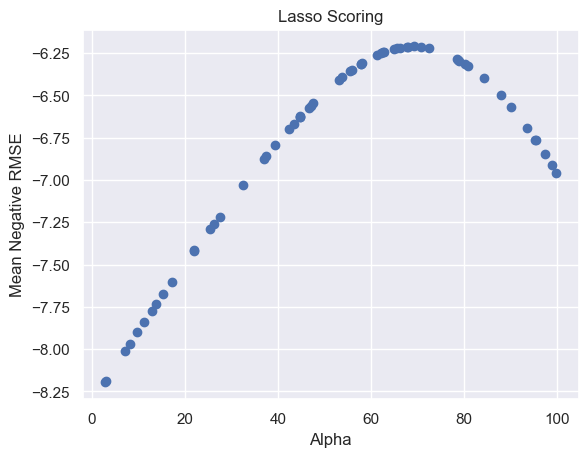

In [45]:
rand_lasso_params = pd.DataFrame(rand_lasso.cv_results_)
plt.plot(rand_lasso_params['param_alpha'], rand_lasso_params['mean_test_neg_root_mean_squared_error'], marker='o',\
         linestyle='none')
plt.title('Lasso Scoring')
plt.xlabel('Alpha')
plt.ylabel('Mean Negative RMSE')
plt.show()

In [46]:
lasso = linear_model.Lasso(alpha=rand_lasso.best_params_['alpha'], random_state = 15)
lasso.fit(X_tr, y_tr)
y_pred = lasso.predict(X_te)
new_row = pd.DataFrame([{'Model' : 'Lasso', '% Train Data' : 10, 'MSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
print(mean_squared_error(y_te, y_pred))

C:\Users\zbro1\anaconda\envs\MOF\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.190e+03, tolerance: 8.165e+02
  model = cd_fast.enet_coordinate_descent(


39.6667202602123


In [47]:
parameters = {'max_features': sp_randFloat(0.1, 0.9),
             'max_depth': sp_randInt(6,12),
             'min_samples_leaf': sp_randInt(200,800),
             'n_estimators': sp_randInt(500,1500)
             }
forest = RandomForestRegressor(n_jobs=-1, random_state=15)
forest_reg = RandomizedSearchCV(forest, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=15)
rand_forest = forest_reg.fit(X_tr, y_tr)
rand_forest.best_params_

KeyboardInterrupt: 

In [ ]:
opt_forest = RandomForestRegressor(n_estimators=rand_forest.best_params_['n_estimators'],\
                                   max_features=rand_forest.best_params_['max_features'],\
                                   min_samples_leaf=rand_forest.best_params_['min_samples_leaf'],\
                                   max_depth=rand_forest.best_params_['max_depth'], n_jobs = -1, random_state=15)
opt_forest.fit(X_tr, y_tr)
y_pred = opt_forest.predict(X_te)
new_row = pd.DataFrame([{'Model' : 'Random Forest', '% Train Data' : 10, 'MSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te, y_pred)

In [ ]:
X_tr.columns = X_tr.columns.str.replace('[', '_')
X_tr.columns = X_tr.columns.str.replace(']', '_')
X_tr.columns = X_tr.columns.str.replace(' ', '_')
X_tr.columns = X_tr.columns.str.replace(',', '_')
X_te.columns = X_te.columns.str.replace('[', '_')
X_te.columns = X_te.columns.str.replace(']', '_')
X_te.columns = X_te.columns.str.replace(' ', '_')
X_te.columns = X_te.columns.str.replace(',', '_')

In [ ]:
xgb = XGBRegressor()
parameters = {'n_estimators': sp_randInt(500,1000),
             'max_depth': sp_randInt(2,12),
             'eta': sp_randFloat(0.0001,0.99),
             'colsample_bytree': sp_randFloat(0.01,0.99)} 
rand_xgb = RandomizedSearchCV(xgb, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=15)
xgbooster = rand_xgb.fit(X_tr, y_tr)
xgbooster.best_params_

In [ ]:
xgb_model = XGBRegressor(n_estimators=xgbooster.best_params_['n_estimators'],\
                                   eta=xgbooster.best_params_['eta'],\
                                   colsample_bytree=xgbooster.best_params_['colsample_bytree'],\
                                   max_depth=xgbooster.best_params_['max_depth'])
xgb_model.fit(X_tr, y_tr)
y_pred = xgb_model.predict(X_te)
new_row = pd.DataFrame([{'Model' : 'XGBoost', '% Train Data' : 10, 'MSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te, y_pred)

In [ ]:
xgb_linear = XGBRegressor(booster = 'gblinear', verbosity = 0)
parameters = {'reg_lambda': sp_randFloat(0,1),
             'reg_alpha': sp_randFloat(0, 1),
             'feature_selector': ['cyclic', 'shuffle']}
rand_xgb_linear = RandomizedSearchCV(xgb_linear, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=15)
xgbooster_linear = rand_xgb_linear.fit(X_tr, y_tr)
xgbooster_linear.best_params_

In [ ]:
xgb_model_linear = XGBRegressor(booster = 'gblinear', reg_lambda = xgbooster_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_linear.best_params_['feature_selector'])
xgb_model_linear.fit(X_tr, y_tr)
y_pred = xgb_model_linear.predict(X_te)
new_row = pd.DataFrame([{'Model' : 'XGBoost Linear', '% Train Data' : 10, 'MSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te, y_pred)

In [ ]:
xgb_coord_desc = XGBRegressor(booster = 'gblinear', updater = 'coord_descent', verbosity = 0)
parameters = {'reg_lambda': sp_randFloat(0,1),
             'reg_alpha': sp_randFloat(0, 1),
             'feature_selector': ['random', 'greedy', 'thrifty']}
rand_xgb_cd = RandomizedSearchCV(xgb_coord_desc, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=15)
xgbooster_linear_cd = rand_xgb_cd.fit(X_tr, y_tr)
xgbooster_linear_cd.best_params_

In [ ]:
xgb_model_lcd = XGBRegressor(booster = 'gblinear', updater = 'coord_descent',\
                                reg_lambda = xgbooster_linear.best_params_['reg_lambda'],\
                                   reg_alpha=xgbooster_linear.best_params_['reg_alpha'],\
                                   feature_selector=xgbooster_linear.best_params_['feature_selector'])
xgb_model_lcd.fit(X_tr, y_tr)
y_pred = xgb_model_lcd.predict(X_te)
new_row = pd.DataFrame([{'Model' : 'XGBoost Linear Coord Desc', '% Train Data' : 10, 'MSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te, y_pred)

In [ ]:
d_tree = tree.DecisionTreeRegressor(random_state = 12)
parameters = {'max_depth': sp_randInt(2,10),
             'min_samples_leaf': sp_randInt(100,5000)}
rand_tree = RandomizedSearchCV(d_tree, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=15)
decision_tree = rand_tree.fit(X_tr, y_tr)
decision_tree.best_params_

In [ ]:
decision_tree_model = tree.DecisionTreeRegressor(max_depth = decision_tree.best_params_['max_depth'],\
                                            min_samples_leaf = decision_tree.best_params_['min_samples_leaf'],\
                                            random_state = 15)
decision_tree_model.fit(X_tr, y_tr)
y_pred = decision_tree_model.predict(X_te)
new_row = pd.DataFrame([{'Model' : 'Decision Tree', '% Train Data' : 10, 'MSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te, y_pred)

In [ ]:
neighbors = KNeighborsRegressor()
parameters = {'n_neighbors': sp_randInt(2,50)}
rand_knn = RandomizedSearchCV(neighbors, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=15, cv=5, random_state=15)
opt_nn = rand_knn.fit(X_tr, y_tr)
opt_nn.best_params_

In [ ]:
knn_opt = KNeighborsRegressor(n_neighbors = opt_nn.best_params_['n_neighbors'])
knn_opt.fit(X_tr, y_tr)
y_pred = knn_opt.predict(X_te)
new_row = pd.DataFrame([{'Model' : 'KNN', '% Train Data' : 10, 'MSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te, y_pred)

In [ ]:
lgbm = lgb.LGBMRegressor(objective = 'regression', metric = 'mae')
parameters = {'num_leaves': sp_randInt(10,1000),
              'n_estimators': sp_randInt(10,1000),
              'max_depth': sp_randInt(2,10),
              'learning_rate': sp_randFloat(0.001,1)}
rand_lgbm = RandomizedSearchCV(lgbm, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=15)
opt_lgbm = rand_lgbm.fit(X_tr, y_tr)
opt_lgbm.best_params_

In [ ]:
lgbm_opt = lgb.LGBMRegressor(objective = 'regression', metric = 'mae', num_leaves = opt_lgbm.best_params_['num_leaves'],\
                             n_estimators = opt_lgbm.best_params_['n_estimators'],\
                             max_depth = opt_lgbm.best_params_['max_depth'],\
                             learning_rate = opt_lgbm.best_params_['learning_rate'])
lgbm_opt.fit(X_tr, y_tr)
y_pred = lgbm_opt.predict(X_te)
new_row = pd.DataFrame([{'Model' : 'Light GBM', '% Train Data' : 10, 'MSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te, y_pred)